In [6]:
import warnings
warnings.filterwarnings('ignore')
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
from keras.layers import Dropout
from sklearn.metrics import mean_squared_error
from math import sqrt

plt.style.use('fivethirtyeight')

df = web.DataReader('TSLA', data_source='yahoo', start='2013-01-01', end='2020-02-06')
df.tail(10)

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-01-24,114.772003,110.851997,114.125999,112.963997,71768000,112.963997
2020-01-27,112.888000,107.856003,108.398003,111.603996,68040500,111.603996
2020-01-28,115.362000,111.615997,113.697998,113.379997,58942500,113.379997
2020-01-29,117.959999,113.486000,115.138000,116.197998,89007500,116.197998
2020-01-30,130.175995,123.599998,126.484001,128.162003,145028500,128.162003
2020-01-31,130.600006,126.503998,128.000000,130.113998,78596500,130.113998
2020-02-03,157.227997,134.703995,134.738007,156.000000,235325000,156.000000
2020-02-04,193.798004,166.776001,176.591995,177.412003,304694000,177.412003
2020-02-05,169.195999,140.822006,164.651993,146.940002,242119000,146.940002


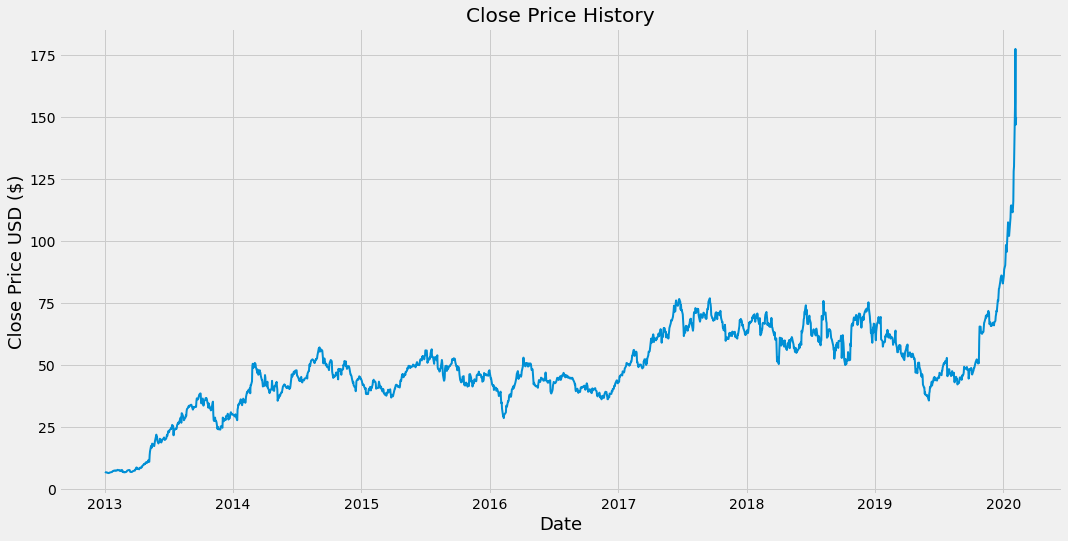

In [7]:
plt.figure(figsize=(16,8))
plt.title('Close Price History')
plt.plot(df['Close'],linewidth=2)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Close Price USD ($)', fontsize=18)
plt.show()

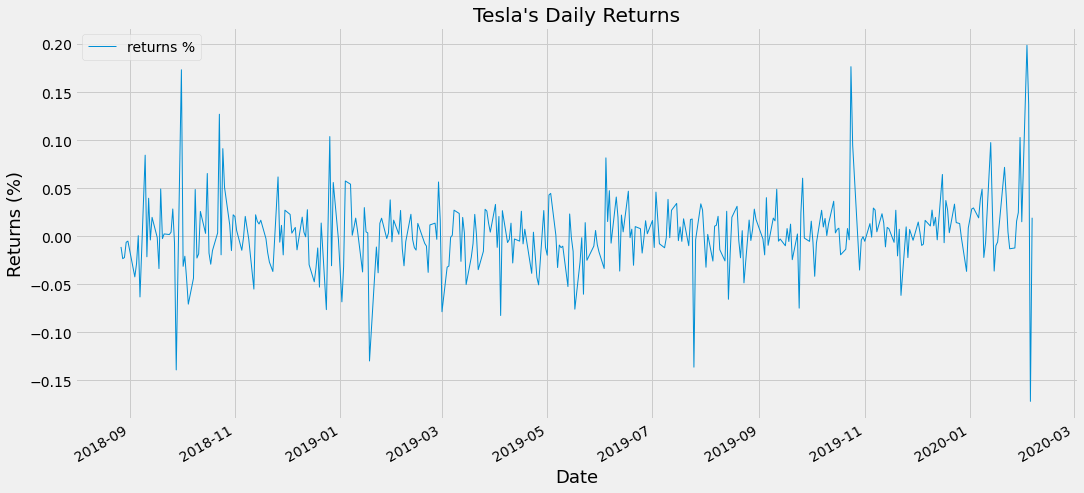

In [8]:
last= df.tail(365)
plt.figure(figsize=(16,8))
plt.title("Tesla's Daily Returns")
returns = last['Close'] / last['Close'].shift(1) - 1
returns.plot(label='returns %',linewidth=1)
plt.xlabel('Date', fontsize=18)
plt.ylabel('Returns (%)', fontsize=18)
plt.legend(loc='upper left')

Text(0.5, 1.0, 'Tesla - 50 vs 200 day Moving Average')

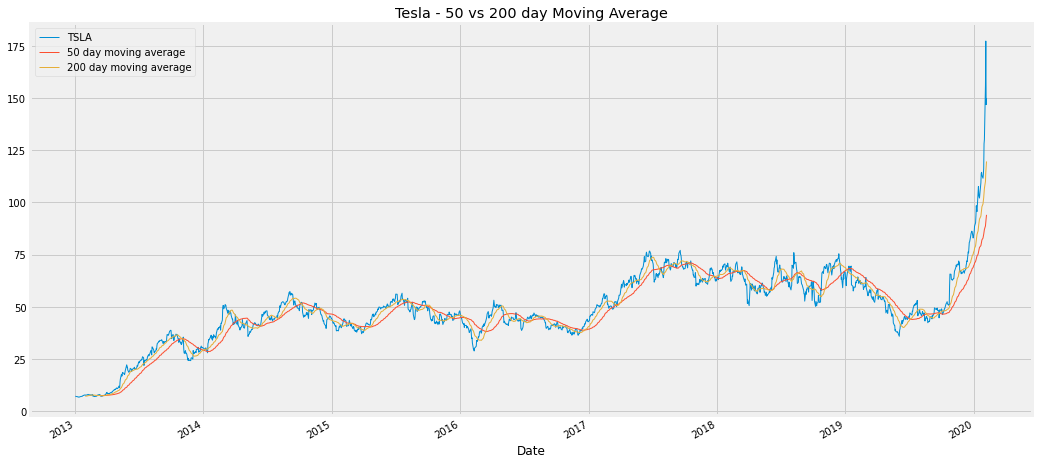

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import style
mavg50 = df['Close'].rolling(window=50).mean()
mavg200 = df['Close'].rolling(window=20).mean()
import matplotlib as mpl
mpl.rc('figure', figsize=(16,8))

df['Close'].plot(label='TSLA',linewidth=1)
mavg50.plot(label='50 day moving average',linewidth=1)
mavg200.plot(label='200 day moving average',linewidth=1)
plt.legend(loc='upper left')
plt.title("Tesla - 50 vs 200 day Moving Average")

In [10]:
#Create a new dataframe with only the 'Close column
data = df.filter(['Close'])
dataset = data.values

In [11]:
#Using 80% of the data as traning data
training_data_len = math.ceil( len(dataset) * .8 )

In [12]:
#Scale the data
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(dataset)

In [13]:
#Create the training data set
train_data = scaled_data[0:training_data_len , :]
#Split the data into x_train and y_train data sets
x_train = []
y_train = []
for i in range(60, len(train_data)):
  x_train.append(train_data[i-60:i, 0])
  y_train.append(train_data[i, 0])

In [14]:
#Creating numpy arrays

x_train, y_train = np.array(x_train), np.array(y_train)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

In [15]:
#Creating the Neural Network - LSTM

model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape= (x_train.shape[1], 1)))
model.add(LSTM(50, return_sequences= False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, batch_size=5, epochs=5)

Epoch 1/5
274/274 [==============================] - 23s 35ms/step - loss: 0.0012
Epoch 2/5
274/274 [==============================] - 10s 37ms/step - loss: 3.1708e-04
Epoch 3/5
274/274 [==============================] - 8s 28ms/step - loss: 2.6803e-04
Epoch 4/5
274/274 [==============================] - 7s 27ms/step - loss: 2.5216e-04
Epoch 5/5
274/274 [==============================] - 7s 26ms/step - loss: 2.1537e-04


In [16]:
#Creating the test set
test_data = scaled_data[training_data_len - 60: , :]
x_test = []
y_test = dataset[training_data_len:, :]
for i in range(60, len(test_data)):
  x_test.append(test_data[i-60:i, 0])
x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1 ))

In [17]:
#Get predictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)

In [18]:
#Root mean squared error 
rmse=sqrt(mean_squared_error(predictions, y_test))
rmse

4.375526414598998

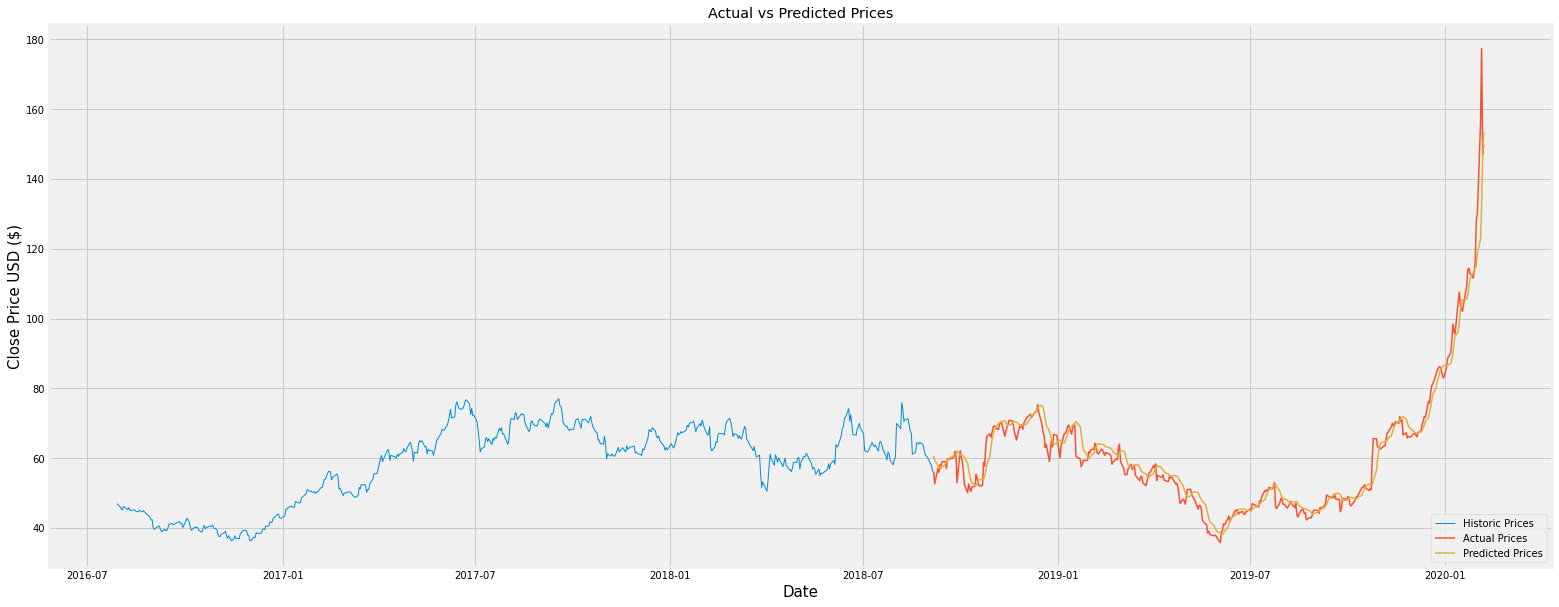

In [19]:
#Plot the data
train = data[900:training_data_len]
valid = data[training_data_len:]

valid['Predictions'] = predictions
plt.figure(figsize=(24,10))
plt.title('Actual vs Predicted Prices')
plt.xlabel('Date', fontsize=15)
plt.ylabel('Close Price USD ($)', fontsize=15)
plt.plot(train['Close'],linewidth=1)
plt.plot(valid[['Close', 'Predictions']],linewidth=1.5)
plt.legend(['Historic Prices', 'Actual Prices', 'Predicted Prices'], loc='lower right')
plt.show()

In [20]:
#Show the Actual vs. Predicted values
valid.tail(10)
training_data_len

1430

In [21]:
#Creating a loop that checks if the prices have increased or decreased day vs. day+1 and seeing if actual vs predicted was correct
valid['Actual']= ''
valid['Predicted']= ''
valid['Recommendation']= ''

for i in range(0,len(valid)-1):
    if valid['Close'][i]<valid['Close'][i+1]:
        valid['Actual'][i+1]= "Increase"
    else:
        valid['Actual'][i+1]= "Decrease"
    if valid['Predictions'][i]<valid['Predictions'][i+1]:
        valid['Predicted'][i+1]= "Increase"
    else:
        valid['Predicted'][i+1]= "Decrease" 

for i in range(1,len (valid)):
    if valid['Actual'][i] == valid['Predicted'][i]:
        valid['Recommendation'][i]= "Correct"
    else:
        valid['Recommendation'][i]= "Incorrect" 

In [22]:
valid.tail(10)

,Close,Predictions,Actual,Predicted,Recommendation
Date,,,,,
2020-01-24,112.963997,111.325623,Decrease,Increase,Incorrect
2020-01-27,111.603996,113.047562,Decrease,Increase,Incorrect
2020-01-28,113.379997,113.860619,Increase,Increase,Correct
2020-01-29,116.197998,114.438156,Increase,Increase,Correct
2020-01-30,128.162003,115.324211,Increase,Increase,Correct
2020-01-31,130.113998,118.596870,Increase,Increase,Correct
2020-02-03,156.000000,122.702080,Increase,Increase,Correct
2020-02-04,177.412003,131.898071,Increase,Increase,Correct
2020-02-05,146.940002,146.268143,Decrease,Increase,Incorrect


In [24]:
from pandas.plotting import lag_plot
from pandas import datetime
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error

Text(0.5, 1.0, 'Tesla Autocorrelation plot')

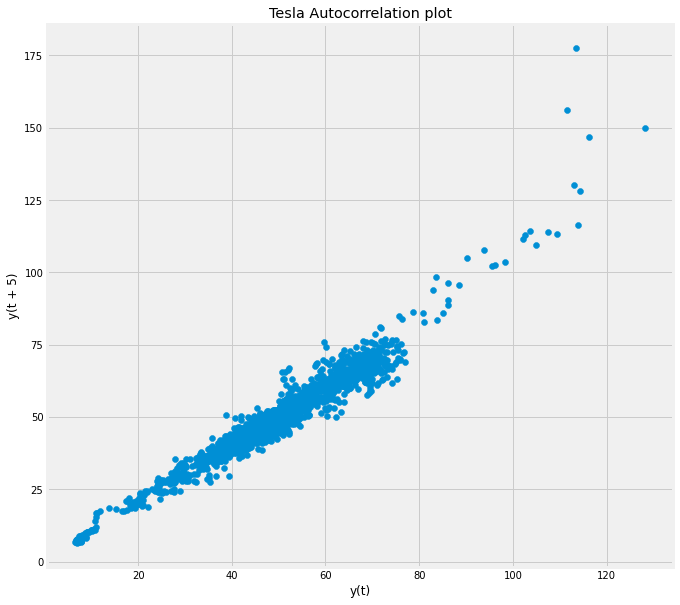

In [25]:
plt.figure(figsize=(10,10))
lag_plot(df['Close'], lag=5)
plt.title('Tesla Autocorrelation plot')

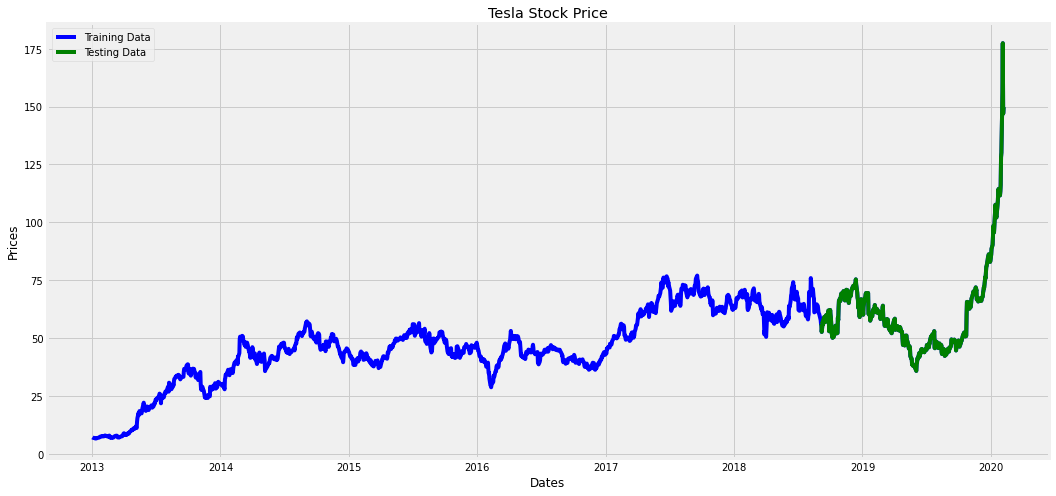

In [26]:
train_data, test_data = df[0:int(len(df)*0.8)], df[int(len(df)*0.8):]
plt.figure(figsize=(16,8))
plt.title('Tesla Stock Price')
plt.xlabel('Dates')
plt.ylabel('Prices')
plt.plot(df['Close'], 'blue', label='Training Data')
plt.plot(test_data['Close'], 'green', label='Testing Data')

plt.legend()

In [27]:
#Calculating
def smape_kun(y_true, y_pred):
    return np.mean((np.abs(y_pred - y_true) * 200/ (np.abs(y_pred) + np.abs(y_true))))

In [31]:
import statsmodels.api as sm
train_ar = train_data['Close'].values
test_ar = test_data['Close'].values

# https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
history = [x for x in train_ar]
print(type(history))
predictions = list()
for t in range(len(test_ar)):
    model = sm.tsa.arima.ARIMA(history, order=(5,1,0))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test_ar[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test_ar, predictions)
print('Testing Mean Squared Error: %.3f' % error)
error2 = smape_kun(test_ar, predictions)
print('Symmetric mean absolute percentage error: %.3f' % error2)

<class 'list'>
Testing Mean Squared Error: 11.486
Symmetric mean absolute percentage error: 2.541


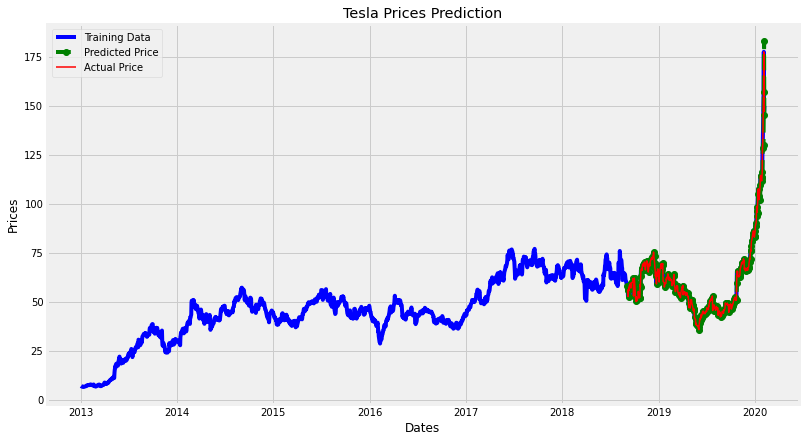

In [32]:
plt.figure(figsize=(12,7))
plt.plot(df['Close'], 'green', color='blue', label='Training Data')
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price',linewidth=1.5,)
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend()

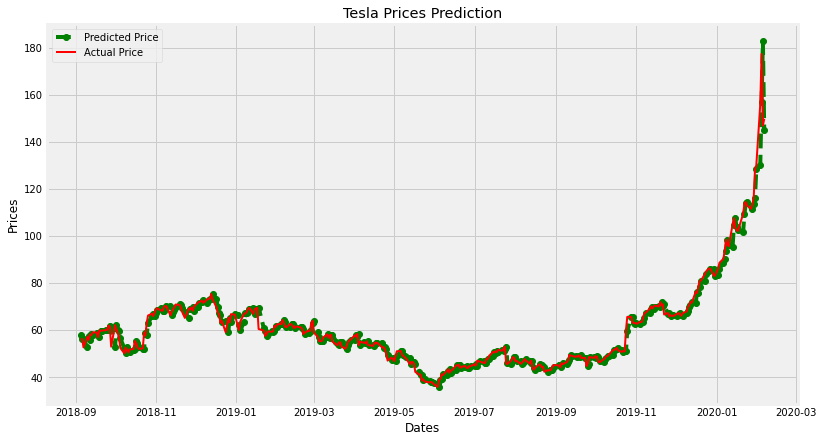

In [33]:
plt.figure(figsize=(12,7))
plt.plot(test_data.index, predictions, color='green', marker='o', linestyle='dashed', 
         label='Predicted Price')
plt.plot(test_data.index, test_data['Close'], color='red', label='Actual Price',linewidth= 2)
plt.title('Tesla Prices Prediction')
plt.xlabel('Dates')
plt.ylabel('Prices')

plt.legend()